Save IBM Account to use QiskitRuntimeService

In [87]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="bfd47f6c166ccc7e37b76ce961efa1d03b40268212f1c39cc972fc488d84a30ba416e6b7977da5b9309c214945671771fb58c97703d56e84be109c8dfe32a47c", overwrite=True)

# Load saved credentials
service = QiskitRuntimeService()

Following block generates and returns the circuit. It also draws the circuit for debugging/visual purposes.

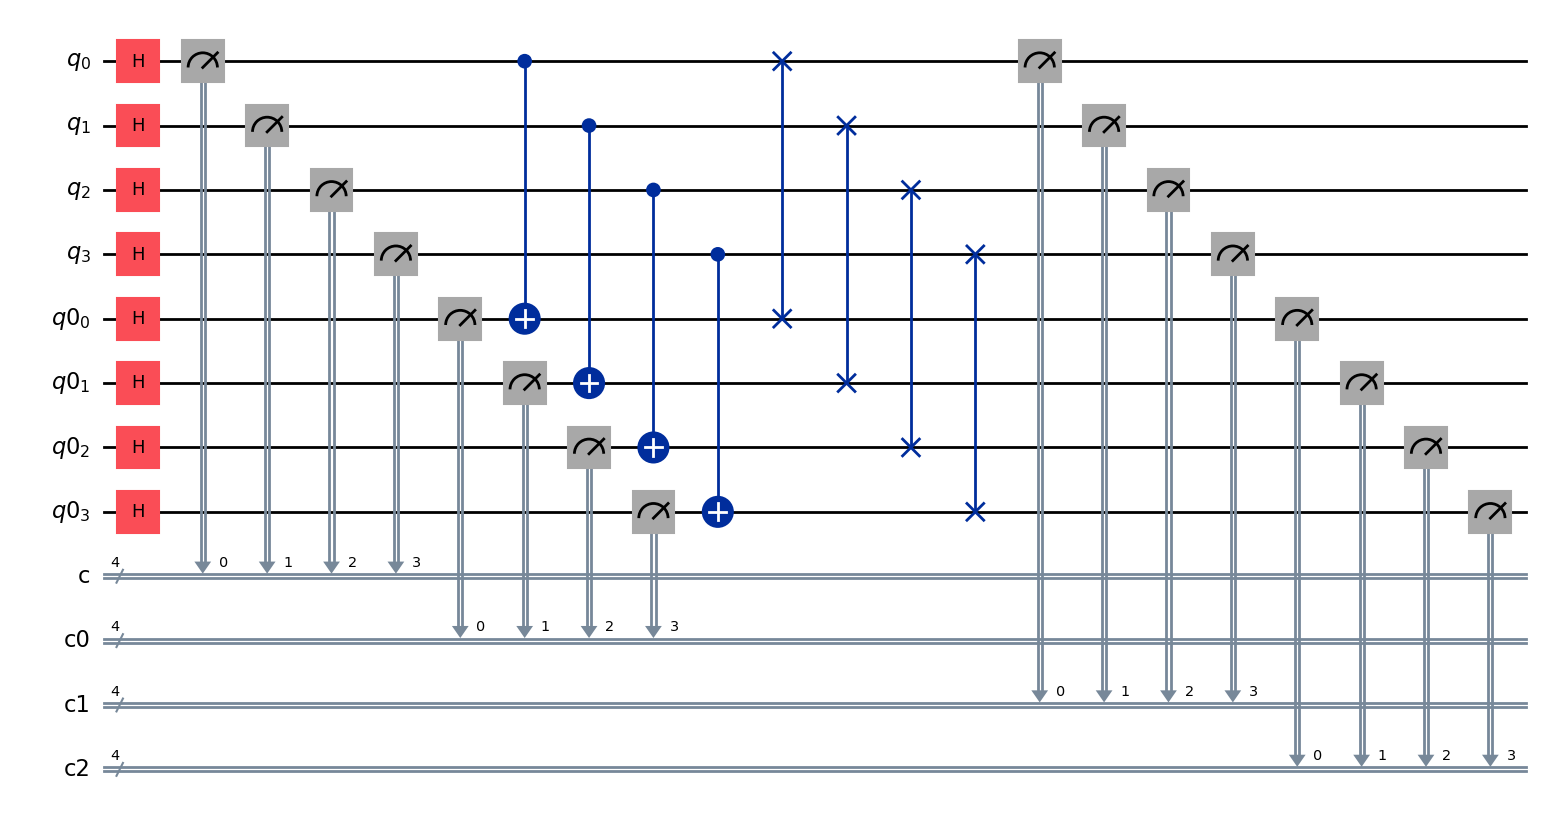

In [79]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

def get_circuit():

    """
    This function returns a quantum circuit that generates two 4-qubit random numbers using Hadamard gates and measurements.
    The function creates two sets of 4-qubit quantum registers and classical registers for measurement.
    It applies Hadamard gates to each qubit in both registers to create superpositions, effectively putting each qubit into
    a state where it can represent either 0 or 1 with equal probability. Then, it measures each qubit in both registers,
    collapsing the superposition into classical bits, effectively generating random 4-qubit numbers for each register.
    Next, it applies CNOT gates between corresponding qubits in the two registers, using the first register as control
    and the second register as target. This entangles the qubits in both registers.
    Finally, it swaps the bits of both quantum registers, further manipulating the qubits.
    The subsequent gates and swaps in the circuit manipulate and entangle the qubits further.
    Returns:
    QuantumCircuit: The quantum circuit that generates two 4-qubit random numbers and does further processing on it (Circuit itself does no useful task)
    
    """

    # first 4 bit quantum register
    qreg_q = QuantumRegister(4, 'q')

    # first 4 bit quantum regsiter
    qreg_q0 = QuantumRegister(4, 'q0')

    # classical registers for measurement
    creg_c = ClassicalRegister(4, 'c')
    creg_c0 = ClassicalRegister(4, 'c0')
    creg_c1 = ClassicalRegister(4, 'c1')
    creg_c2 = ClassicalRegister(4, 'c2')

    # Build the circuit
    circuit = QuantumCircuit(qreg_q, qreg_q0, creg_c, creg_c0, creg_c1, creg_c2)

    # Apply Hadamard gates to each qubit in both registers
    circuit.h(qreg_q)
    circuit.h(qreg_q0)

    # Measure qubits in both registers
    circuit.measure(qreg_q, creg_c)
    circuit.measure(qreg_q0, creg_c0)

    # Apply CNOT gates between corresponding qubits in the two registers (q provides control bit)
    circuit.cx(qreg_q, qreg_q0)

    # Swap bits of both quantum registers
    circuit.swap(qreg_q, qreg_q0)

    # Measure qubits in both registers
    circuit.measure(qreg_q, creg_c1)
    circuit.measure(qreg_q0, creg_c2)

    return circuit

qc = get_circuit()
qc.draw(output='mpl')

Following Block executes the Circuit on AerSimulator (a local simulator)

In [81]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np

qc=get_circuit()
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)

# Transpile the circuit
transpiled_circuit = transpile(isa_qc, backend=aer_sim)

# Run the transpiled circuit
result = aer_sim.run(transpiled_circuit).result()

# Get the counts from the result
counts = result.get_counts()

In [82]:
# Print the counts of result from Aersimulator
print(counts)

{'1100 0000 1100 1100': 5, '1010 1101 0111 1010': 2, '0001 0101 0100 0001': 1, '1000 1101 0101 1000': 6, '1110 1111 0001 1110': 4, '0110 1000 1110 0110': 4, '0011 0001 0010 0011': 3, '1110 0101 1011 1110': 4, '0100 1001 1101 0100': 6, '0001 0010 0011 0001': 5, '0001 1111 1110 0001': 2, '0011 0010 0001 0011': 6, '0011 1110 1101 0011': 4, '0010 1001 1011 0010': 5, '1000 1110 0110 1000': 2, '0101 0101 0000 0101': 2, '1010 0110 1100 1010': 3, '0110 1010 1100 0110': 5, '1110 1110 0000 1110': 5, '1001 0110 1111 1001': 5, '0110 1011 1101 0110': 6, '0101 0111 0010 0101': 7, '0010 1110 1100 0010': 5, '0110 0001 0111 0110': 3, '0010 0111 0101 0010': 8, '0100 1011 1111 0100': 3, '0111 1000 1111 0111': 2, '0100 0110 0010 0100': 2, '1001 1100 0101 1001': 5, '1111 0101 1010 1111': 6, '0110 1101 1011 0110': 4, '0000 0101 0101 0000': 10, '0110 1001 1111 0110': 6, '0001 1001 1000 0001': 5, '0001 0111 0110 0001': 6, '1011 0110 1101 1011': 5, '1011 1111 0100 1011': 5, '0011 1100 1111 0011': 2, '0101 1011

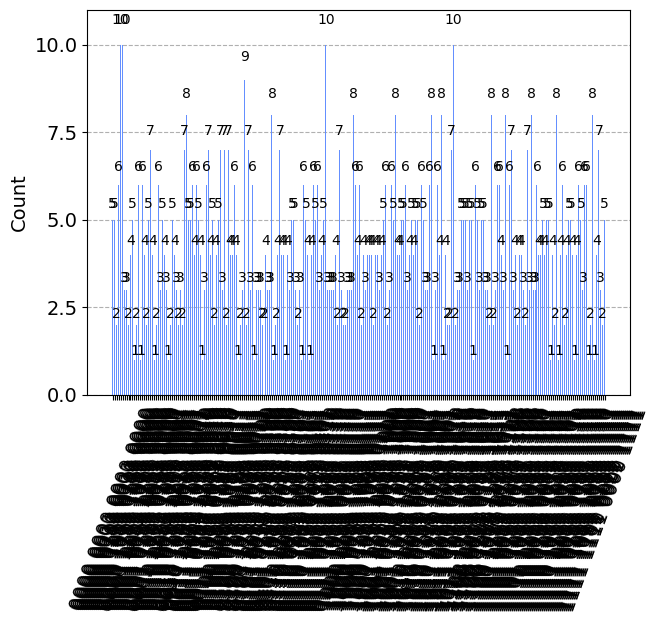

In [83]:
# Plot histogram
plot_histogram(counts)

To simulate with noise, we specify a system (ibm_brisbane) and submit it to Aer. Aer builds a noise model based on the calibration data from that system, and instantiates an Aer backend with that model. 

In [84]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")

# Build Aer backend with the noise model
aer_with_noise = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator with noise
pm_with_noise = generate_preset_pass_manager(backend=aer_with_noise, optimization_level=1)
isa_qc_with_noise = pm_with_noise.run(qc)
sampler = Sampler(backend=aer_with_noise)
result_with_noise = sampler.run([isa_qc_with_noise]).result()

Plotting results with Noise

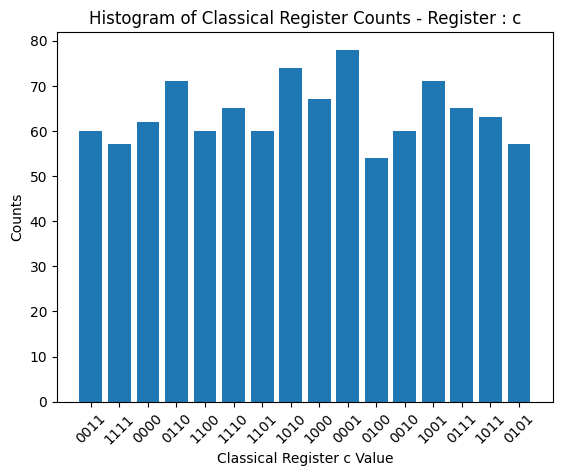

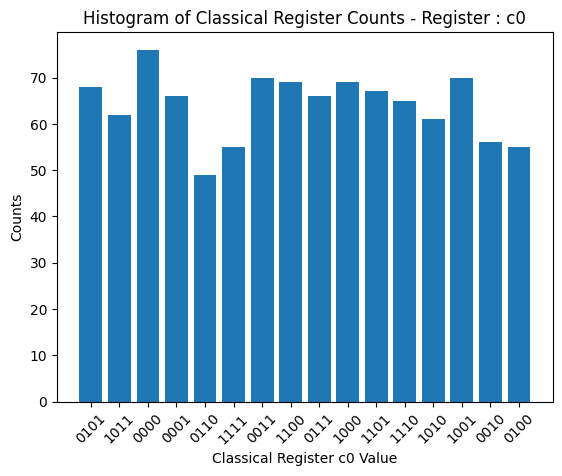

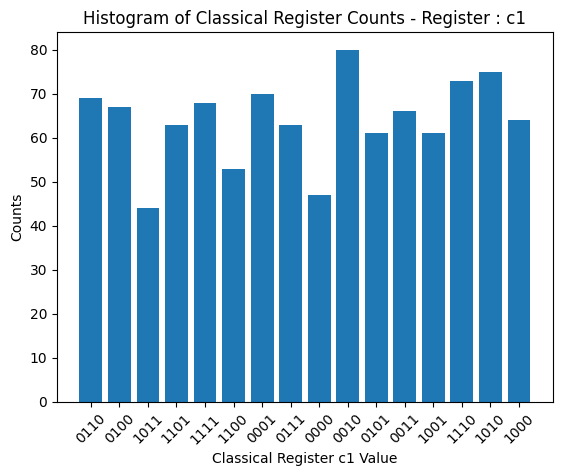

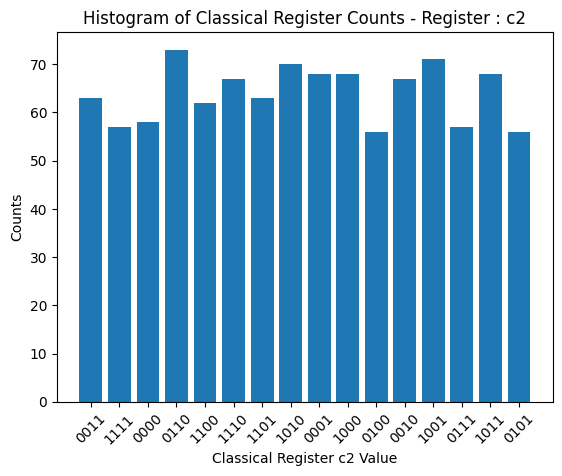

In [85]:
import matplotlib.pyplot as plt

def plot_count(counts, register_name):
   # Plot histogram
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(f'Classical Register {register_name} Value')
    plt.ylabel('Counts')
    plt.title(f'Histogram of Classical Register Counts - Register : {register_name}')
    plt.xticks(rotation=45)
    plt.show()

# Plot results with noise
data = result_with_noise[0].data
plot_count(data.c.get_counts(), 'c')
plot_count(data.c0.get_counts(), 'c0')
plot_count(data.c1.get_counts(), 'c1')
plot_count(data.c2.get_counts(), 'c2')


Now we add another type of noise: "Depolarizing Error"
When we add a depolarizing error to gates ['u1', 'u2', 'u3', 'id'], we effectively add noise to all single-qubit gates in your circuit, including the Hadamard gate (h). We also apply noise to cnot and swap.

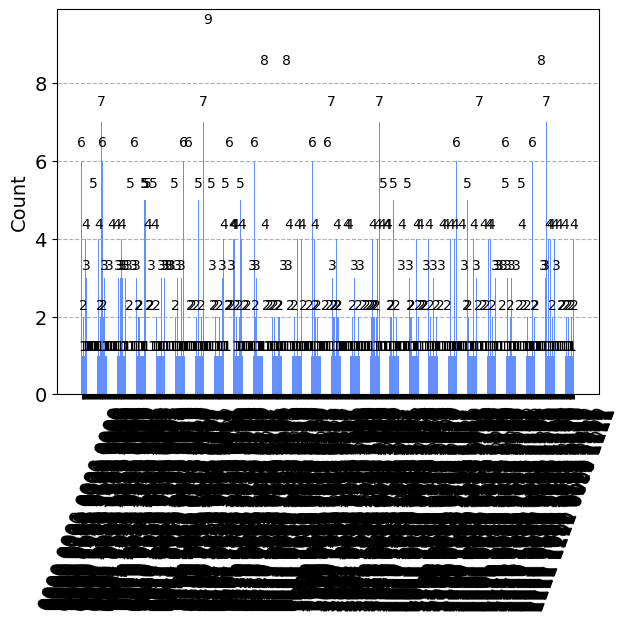

In [89]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)
from qiskit.visualization import plot_histogram

# Create a noise model and add depolarizing error to single-qubit gates
def create_noise_model(error_probability):
    noise_model = NoiseModel()
    depolarizing_error_single = depolarizing_error(error_probability, 1)
    noise_model.add_all_qubit_quantum_error(depolarizing_error_single, ['u1', 'u2', 'u3', 'id'])
    # Add depolarizing error to CNOT gates
    depolarizing_error_cx = depolarizing_error(error_probability, 2)
    noise_model.add_all_qubit_quantum_error(depolarizing_error_cx, ['cx'])
    # Add depolarizing error to SWAP gates
    depolarizing_error_swap = depolarizing_error(error_probability, 2)
    noise_model.add_all_qubit_quantum_error(depolarizing_error_swap, ['swap'])
    return noise_model

# Define the error probability
error_probability = 0.05

# Get the circuit
qc = get_circuit()

# Create the noise model
noise_model = create_noise_model(error_probability)

# Transpile the circuit with the noise model
simulator = AerSimulator()
noisy_circuit = transpile(qc, simulator, optimization_level=0)

# Simulate the noisy circuit
result = simulator.run(noisy_circuit, noise_model=noise_model).result()

# Get the counts from the result
counts = result.get_counts()

# Plot the histogram of counts
plot_histogram(counts)
